# Histogram of differences of Exponential Moving Averages (EMAs) as proxy for change

This notebook shows the use of a histogram of the difference of a pixel-wise fast and slow exponential moving average as a proxy for rate of change of the observed scattering signal, which itself may be used as a proxy for changes in the physical characteristics of the sample

In [1]:
from numpy import ndarray, dtype, floating, bool_, s_, linspace, histogram, zeros
from matplotlib.pyplot import figure, imshow
from matplotlib.colors import LogNorm

from adcorr.corrections import mask_frames
from sample_degradation.reading import map_frames, load_data

In [2]:
FILE_PATH = "/dls/i22/data/2022/sm30693-1/i22-623617.nxs"
FRAMES_KEY = "entry1/instrument/detector/data"

FAST = 0.8
SLOW = 0.6
BIN_WIDTH = 1.0

In [3]:
mask: ndarray[tuple[int, int], bool_] = load_data(FILE_PATH, "entry1/instrument/detector/pixel_mask")

In [4]:
counts_list: list[ndarray] = list()
bounds_list: list[tuple[int, int]] = list()

for idx, frame in enumerate(map_frames(FILE_PATH, FRAMES_KEY)):
    masked_frame = mask_frames(frame, mask)
    if idx == 0:
        fast_ema = masked_frame.copy()
        slow_ema = masked_frame.copy()
        continue
    fast_ema = (1 - FAST) * fast_ema + FAST * frame
    slow_ema = (1 - SLOW) * slow_ema + SLOW * frame
    difference = fast_ema - slow_ema
    min_difference = difference.min()
    max_difference = difference.max()
    min_bound = int(min_difference / BIN_WIDTH)
    max_bound = int(max_difference / BIN_WIDTH) + 1
    counts, edges = histogram(
            difference,
            linspace(
                min_bound*BIN_WIDTH,
                max_bound*BIN_WIDTH,
                max_bound - min_bound + 1
            )
        )
    counts_list.append(counts)
    bounds_list.append((min_bound, max_bound))

In [5]:
min_bound = min(bound[0] for bound in bounds_list)
max_bound = max(bound[1] for bound in bounds_list)

counts_map = zeros((len(counts_list), max_bound-min_bound), counts_list[0].dtype)

for idx, (counts, bounds) in enumerate(zip(counts_list, bounds_list)):
    counts_map[idx, (bounds[0] - min_bound):(bounds[1] - min_bound)] = counts

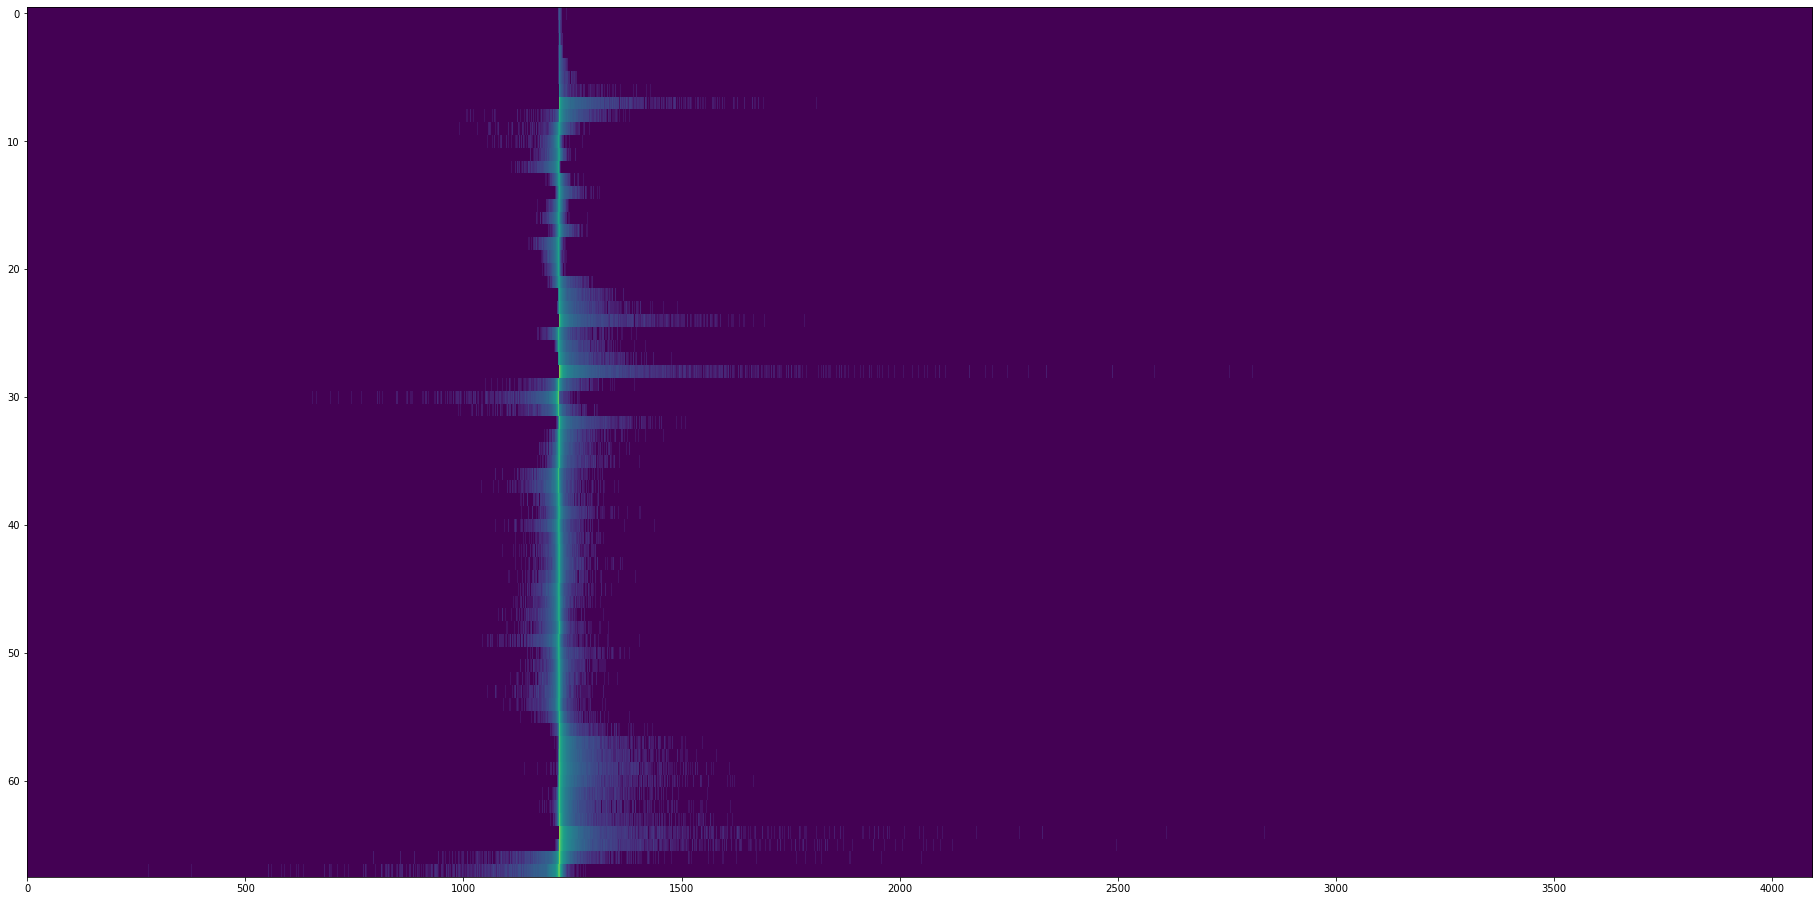

In [6]:
fig = figure(figsize=(32, 16))
imshow(counts_map, aspect='auto', interpolation='none', norm=LogNorm(clip=True))